<div class="alert alert-info" role="alert">
    <h1 style="color:black; font-size:250%; text-align:center" >Análisis de Ventas. Distribuidor Equipo de Montaña<a class='tocSkip'a> </h1>
</div>

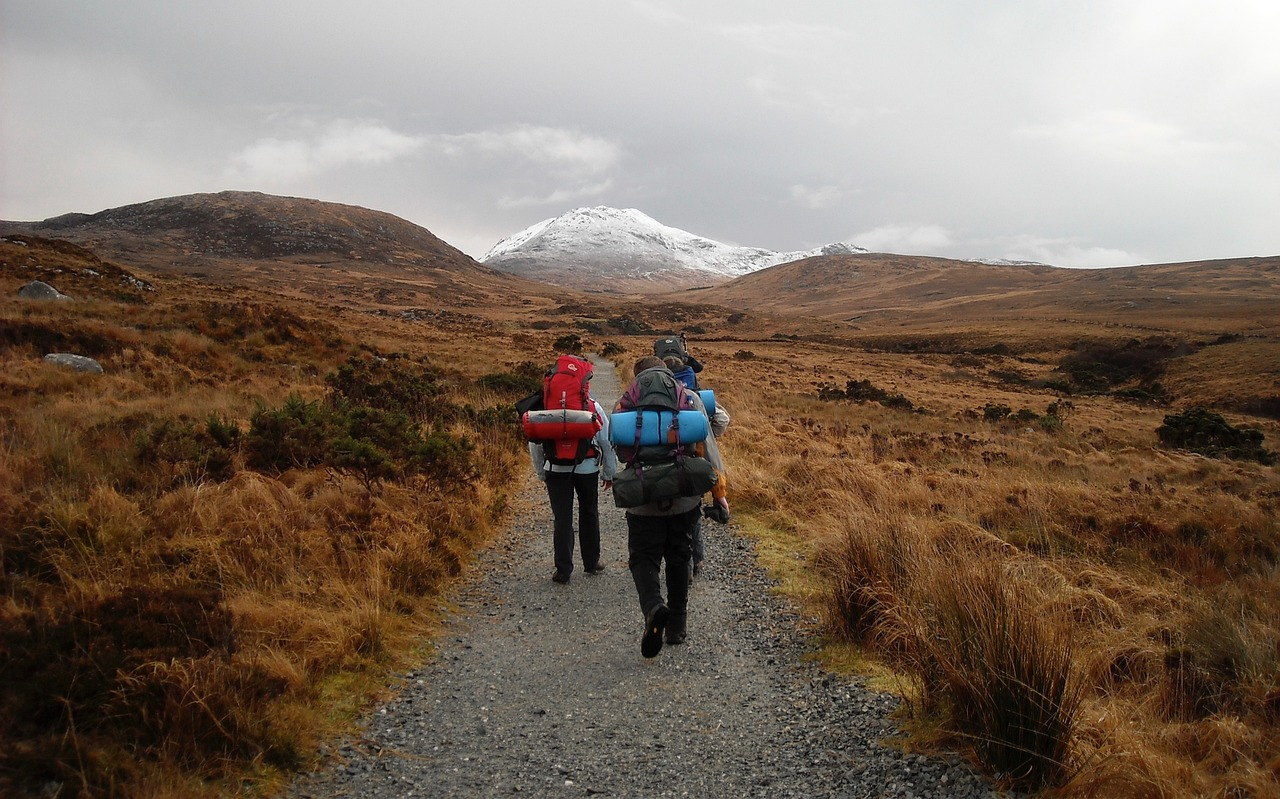

# Introducción <a class="tocSkip">

Con el objetivo de practicar y demostrar habilidad en el manejo del lenguaje **SQL**, a continuación, se harán algunas consultas para analizar la información de una empresa ficticia denominada *Extreme Sports House*, distribuidor líder en equipo de montaña, senderismo y aventura.

<div class=text-justify>
Tradicionalmente, las empresas almacenan y mantienen su información estructurada en sitios denominados Data Warehouse, que facilitan la explotación de los datos y, por ende, los análisis. Para este proyecto, se trabajará primeramente, con MySQL que es una de las herramientas más populares en los entornos empresariales debido a que es open source. La segunda herramienta será Python con este IDE, para poder mostrar los resultados de las consultas y, sobretodo, poder publicar este cuaderno en la web.
<div/>

En resumen, se formularán y contestarán algunas preguntas de negocio, las más comunes que ayuden a generar insights.

# set up <a class="tocSkip">

In [1]:
import pandas as pd
import pymysql
import pymysql.cursors
import credenciales as cds

pd.options.display.float_format = '{:.2f}'.format

# Diagrama ER <a class="tocSkip">

Con el propósito de conocer distintas tablas y sus relaciones, a continuación, se muestra la imagen del modelo de la base de datos:

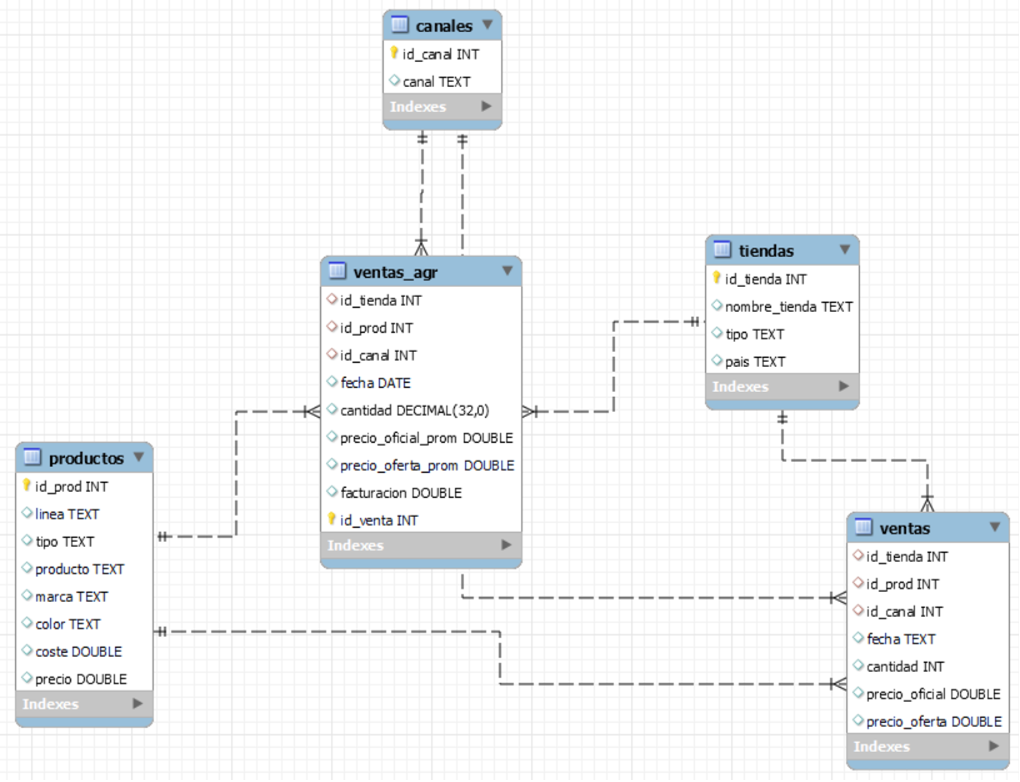

# Conexion a la base de datos <a class="tocSkip">

Antes que nada, hay que establecer la conexion con MySQL. Estaré usando mi equipo como servidor, por lo que, el host será local:

In [2]:
conexion = pymysql.connect(host = "localhost", 
                           user = cds.user, 
                           passwd = cds.passwd, 
                           database = "caso")

cursor = conexion.cursor()

Ya que se estableció la conexión a la base de datos con la que se trabajará, ahora se mostrarán las tablas que contiene  dicha base de datos:

In [3]:
tablas = "SHOW TABLES;"

In [4]:
cursor.execute(tablas)
filas = cursor.fetchall()

print("Tablas de la base 'caso':\n")

for fila in filas:
   print(fila)

conexion.close()

Tablas de la base 'caso':

('canales',)
('productos',)
('recomendador',)
('tiendas',)
('v_matriz_segmentacion',)
('v_segmentacion_matriz_clientes',)
('v_ventas_agr_pedido',)
('ventas',)
('ventas_agr',)


<div class=text-justify>
Para trabajar más comodamente se crea una función, en python, para la ejecución de las consultas, ya que de esa manera, solamente se tendrá que trabajar en la consulta sin la necesidad de tener que repetir las credenciales para establecer la conexion. Además, al final la salida de las consultas será un dataframe de pandas para facilitar la visualización del resultado, ya que la salida del query es una lista de tuplas, lo cual no es tan amigable de leer.
</div>

In [5]:
def query(DB, consulta):
    
    con = pymysql.connect(
            host = 'localhost',
            user = cds.user,
            password = cds.passwd,
            db = DB,
            cursorclass = pymysql.cursors.DictCursor)

    try:

        with con.cursor() as cur:

            cur.execute(consulta)

            rows = cur.fetchall()
            desc = cur.description

            df_mysql = pd.DataFrame.from_dict(rows, orient = 'columns')

    finally:

        con.close()

    return df_mysql

La primer consulta es para conocer la tabla principal *ventas_agr:*

In [6]:
consulta = "SELECT * FROM ventas_agr;"

In [7]:
query('caso', consulta)

,id_tienda,id_prod,id_canal,fecha,cantidad,precio_oficial_prom,precio_oferta_prom,facturacion,id_venta
0,1201,109110,4,2015-01-12,648,76.86,71.48,46319.04,1
1,1201,112110,4,2015-01-12,799,10.64,10.21,8157.79,2
2,1201,115110,4,2015-01-12,755,10.71,10.28,7761.40,3
3,1205,70240,3,2015-01-12,70,122.70,114.11,7987.70,4
4,1205,71110,3,2015-01-12,28,95.62,92.75,2597.00,5
...,...,...,...,...,...,...,...,...,...
134683,1258,52110,5,2018-07-09,1011,38.00,36.48,36881.28,134684
134684,1258,53110,5,2018-07-09,476,39.99,25.99,12371.24,134685
134685,1258,54110,5,2018-07-09,476,52.99,52.99,25223.24,134686
134686,1258,55110,5,2018-07-09,476,8.00,8.00,3808.00,134687


Todo funciona bien, por lo que, de aquí en adelante se harán consultas más complejas.

# ¿Cual ha sido la evolución mensual de la facturación por canal en los últimos 12 meses completos?

El reultado final debe ser una base con 3 columnas: canal, mes y facturación. La estratégia para conseguir lo anterior será:

1. Relacionar las tablas ventas_agr y canales, por el campo llave id_canal.
2. Filtrar por la fecha para obtener los últimos 12 meses completos.
3. Acumular la facturación por canal y mes.
4. Ordenar en ascendente por las variables id_canal y mes.

In [19]:
consulta = "select canal, month(fecha) as mes, round(sum(facturacion), 2) as facturacion_canal \
            from ventas_agr as v \
            inner join  canales as c \
            on v.id_canal = c.id_canal \
            where fecha between '2017-07-01' and '2018-06-30' \
            group by v.id_canal, 2 \
            order by v.id_canal, mes;"

In [20]:
query('caso', consulta)

,canal,mes,facturacion_canal
0,Fax,1,398846.85
1,Fax,4,405543.97
2,Fax,5,1604.67
3,Telephone,1,356840.39
4,Telephone,2,521377.61
5,Telephone,3,1278588.00
6,Telephone,4,1498352.40
7,Telephone,5,1284276.19
8,Telephone,6,935424.28
9,Telephone,7,1226619.29


# Localiza el nombre de nuestros 20 mejores clientes (tiendas con mayor facturación)


Para obtener el resultado solicitado se procede como sigue:

1. Hacer un inner join entre las tablas ventas_agr y tiendas, por el campo llave id_tienda.
2. Obtener el acumulado de la facturación por tienda.
3. Ordenar en descendente por el acumulado de la facturación por tienda.
3. Mostrar sólo las 20 primeras tiendas.

In [21]:
consulta = "select nombre_tienda, round(sum(facturacion),0) as facturacion_tienda \
            from ventas_agr as v \
            inner join tiendas as t\
            on v.id_tienda = t.id_tienda \
            group by v.id_tienda \
            order by facturacion_tienda desc \
            limit 20;"

In [22]:
query('caso', consulta)

,nombre_tienda,facturacion_tienda
0,Grand choix,67071631.0
1,"Chen Yu Enterprise Co.,",56562862.0
2,VIP Department Stores,43715679.0
3,Leisure Land,39527410.0
4,"Hangzhou Superman Sports Goods Co., LTD.",30171596.0
5,Naranco de Bulnes,29690996.0
6,"ArtÃ­culos de Campismo El Aquila, S.A. de C.V.",29074063.0
7,Sport & Freizeit,28839100.0
8,The Marketplace,28624422.0
9,Golf Shop Jiro,27843203.0


# ¿Cuáles son los 25 productos en los que se obtiene un mayor margen financiero en cada línea de producto?

La estratégia para llegar al resultado y responder a esta pregunta será como sigue:

1. Crear una CTE (Common Table Expressions), para calcular en ella el margen ((precio - coste) / coste) * 100.
2. Apoyarnos de una subconsulta en el from, para crear una window function que genere un ranking por linea de producto.
3. Filtrar esa columna ranking para quedarlos con los primeros 5 registros.

In [23]:
consulta = "with tabla_margen as ( \
                select *, round((precio - coste) / coste, 2) * 100 as margen \
                from productos) \
            select * \
            from (select id_prod, \
                  linea, \
                  producto, \
                  margen, \
                  row_number() over (partition by linea order by margen desc) as ranking \
                  from tabla_margen) as ranking \
            where ranking <= 5;"

In [24]:
query('caso', consulta)

,id_prod,linea,producto,margen,ranking
0,4110,Camping Equipment,TrailChef Cup,331.0,1
1,9110,Camping Equipment,TrailChef Kettle,161.0,2
2,1110,Camping Equipment,TrailChef Water Bag,138.0,3
3,41110,Camping Equipment,Flicker Lantern,125.0,4
4,20110,Camping Equipment,Hibernator Self - Inflating Mat,124.0,5
5,115110,Golf Equipment,Course Pro Gloves,322.0,1
6,112110,Golf Equipment,Course Pro Golf and Tee Set,269.0,2
7,114110,Golf Equipment,Course Pro Golf Bag,175.0,3
8,109110,Golf Equipment,Course Pro Putter,141.0,4
9,110110,Golf Equipment,Blue Steel Putter,121.0,5


# ¿Con qué productos necesitaríamos quedarnos para mantener el 90% de la facturación actual?

Para obtener el resultado solicitado se procede de la siguiente manera:

1. Se crea una primera subconsulta para calcular el acumulado de la facturación por producto.
2. Se hace una segunda subconsulta para poder crear una window function que calcule la sumatoria total de la facturación.
3. Con estas dos subconsultas ya se podrá calcular la facturacion acumulada porcentual por producto.
4. Luego, se incluyen esas dos subconsultas en una tabla temporal CTE, para filtrar la facturacion acumulada porcentual por producto y mantaner los productos que acumulen hasta el 90% de la facturación.

In [25]:
consulta = "with fact_prod_acum_porc as ( \
            select *, round((fact_prod_acum / fact_prod_total), 2) as fact_prod_acum_porc \
            from (select id_prod, \
                  round(sum(facturacion_prod) over (order by facturacion_prod desc), 2) as fact_prod_acum, \
                  sum(facturacion_prod) over() as fact_prod_total \
                  from (select id_prod, \
                        sum(facturacion) as facturacion_prod \
                        from ventas_agr \
                        group by id_prod \
                        order by facturacion_prod desc) as tabla_fact_prod) as tabla_temporal) \
            select id_prod, fact_prod_acum, fact_prod_acum_porc \
            from fact_prod_acum_porc \
            where fact_prod_acum_porc <= 0.9;"

In [26]:
query('caso', consulta)

,id_prod,fact_prod_acum,fact_prod_acum_porc
0,105110,5.676171e+07,0.05
1,11110,1.032222e+08,0.08
2,144180,1.474780e+08,0.12
3,102110,1.917288e+08,0.15
4,106110,2.290458e+08,0.18
...,...,...,...
109,115110,1.120928e+09,0.90
110,130110,1.123758e+09,0.90
111,143120,1.126389e+09,0.90
112,148110,1.129016e+09,0.90


# Y por tanto ¿Qué productos concretos podríamos eliminar y seguir manteniendo el 90% de la facturación?

Para terminar de contestar este tema de la facturación, ya solo se tendrá que hacer lo siguiente:

1. Por conveniencia, se copia el código anterior para utilizarlo dentro de una tabla temporal.
2. Con dicha tabla, se hace un left join con la tabla ventas_agr por el campo llave id del producto.
3. Se aplica un filtro al campo id del produto de la tabla temporal para obtener los valores null.

In [29]:
consulta = "with a_mantener as ( \
                with fact_prod_acum_porc as ( \
                select *, round((fact_prod_acum / fact_prod_total), 2) as fact_prod_acum_porc \
                from (select id_prod, \
                      round(sum(facturacion_prod) over (order by facturacion_prod desc), 2) as fact_prod_acum, \
                      sum(facturacion_prod) over() as fact_prod_total \
                      from (select id_prod, \
                            sum(facturacion) as facturacion_prod \
                            from ventas_agr \
                            group by id_prod \
                            order by facturacion_prod desc) as tabla_fact_prod) as tabla_temporal) \
                select id_prod, fact_prod_acum, fact_prod_acum_porc \
                from fact_prod_acum_porc \
                where fact_prod_acum_porc <= 0.9) \
            select distinct v.id_prod \
            from ventas_agr as v \
                left join a_mantener as m \
                on v.id_prod = m.id_prod \
            where m.id_prod is null;"

In [30]:
query('caso', consulta)

,id_prod
0,1110
1,2110
2,4110
3,10110
4,16110
...,...
125,153110
126,154110
127,154120
128,154130


# ¿Cual es la contribución (en porcentaje) de cada línea de producto al total de facturación?

Para llegar al resultado de la pregunta anterior, la consulta será de la siguiente manera:

1. Se hace un inner join entre las tablas ventas_agr y productos por el campo llave id de producto.
2. Se calcula la sumatoria de la facturación por linea de producto.
3. Se crea una tabla temporal, para poder calcular el porcentaje de participacion de la facturación por linea de producto en la facturación total.
4. Se ordena de forma descendente por el porcentaje de participación creado en el punto 4.

In [33]:
consulta = "with facturacion_por_linea as ( \
                select linea, round(sum(facturacion), 2) as facturacion_linea \
                from ventas_agr as v \
                inner join productos as p \
                on v.id_prod = p.id_prod \
                group by linea) \
            select linea, \
            facturacion_linea, \
            round(facturacion_linea / sum(facturacion_linea) over(),2) as pct_linea \
            from facturacion_por_linea \
            order by pct_linea desc;"

In [36]:
query('caso', consulta)

,linea,facturacion_linea,pct_linea
0,Personal Accessories,410329373.17,0.33
1,Golf Equipment,331781144.36,0.27
2,Camping Equipment,334691880.37,0.27
3,Mountaineering Equipment,156860394.34,0.13
4,Outdoor Protection,17700970.91,0.01


# Dentro de la línea que más factura ¿Hay algún producto concreto que esté en tendencia? (Definimos tendencia como el crecimiento de Q2-2018 sobre Q1-2018)

Para responder esta pregunta se hará lo siguiente:

1. Hacer un left join entre las tablas ventas_agr y productos, por el campo llave id_prod.
2. Filtrar con un where para trabajar únicamente con la línea de producto Personal Accessories y entre el 2018-01-01 y 2018-06-30.
3. Generar las columnas de trimestre y acumulado de la facturación.
4. Agrupar por producto y trimestre y ordenar descendentemente por producto y trimestre.
5. Guardar los pasos anteriores en una tabla temporal, para poder crear la columna que muestre el crecimiento de un trimestre a otro.
6. Crear una subconsulta en el from, para calcular, con la window function lag(), sobre el total de la facturación, el crecimiento de un trimestre a otro.
7. Filtrar los registros que no son null en la columna del crecimiento creada en el punto 6.
8. Finalmente, ordenar en descendente por la columna de crecimiento.

In [38]:
consulta = "with producto_trimestre as ( \
                select linea, producto, quarter(fecha) as trimestre, sum(facturacion) facturacion_prod \
                from ventas_agr as v \
                    left join productos as p \
                    on v.id_prod = p.id_prod \
                where linea = 'Personal Accessories' and fecha between '2018-01-01' and '2018-06-30' \
                group by producto, 3 \
                order by 2, 3) \
            select producto, crecimiento \
            from ( \
              select linea, \
              producto, \
              trimestre, \
              facturacion_prod, \
              facturacion_prod / lag(facturacion_prod) over (partition by producto order by trimestre) as crecimiento \
            from producto_trimestre) as subconsulta \
            where crecimiento is not null \
            order by crecimiento desc;"

In [39]:
query('caso', consulta)

,producto,crecimiento
0,Glacier Basic,8.77
1,Seeker 35,3.04
2,Seeker Mini,2.14
3,Bear Survival Edge,2.13
4,Seeker Extreme,1.98
5,Capri,1.98
6,Retro,1.56
7,Glacier Deluxe,1.49
8,Trendi,1.42
9,Zodiak,1.40
